### KMeans

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# split para modelado
from sklearn.model_selection import train_test_split
# Scaled | Escalado
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import plotly.express as px
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
# Métricas
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error
from scipy.stats import randint
# To save models
import json
import pickle
#para Kmeans
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score
# Importar el clasificador de XGBoost
from xgboost import XGBClassifier
# Métricas
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="findfont: *")

import matplotlib as mpl
# Configura Matplotlib para usar 'DejaVu Sans' como fuente sans-serif predeterminada
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans']

In [30]:
df = pd.read_csv('../data/processed/df_ini_09housing.csv')

In [31]:
x = df.copy()

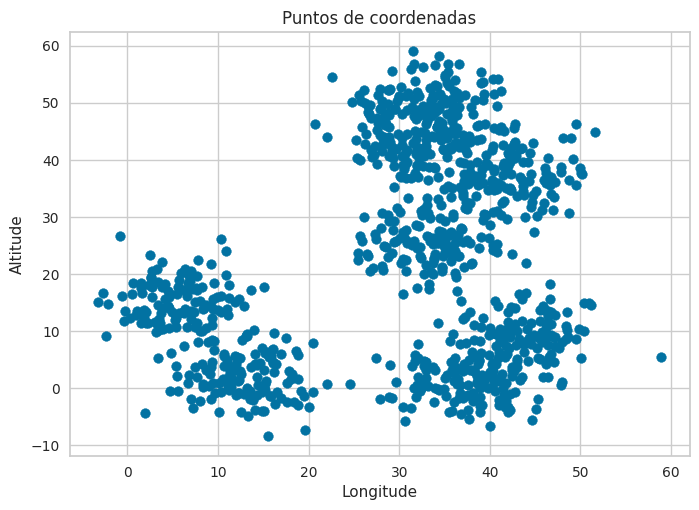

In [32]:
# Generamos el gráfico.
X, _ = make_blobs(center_box=(0,50),
                  n_features=2,
                  n_samples=1000,
                  centers=8,
                  cluster_std=3.8,
                  random_state=18)

plt.scatter(X[:, 0], X[:, 1])
plt.title('Puntos de coordenadas')
plt.xlabel('Longitude')
plt.ylabel('Altitude')
plt.show()

In [33]:
# Escalado de valores Min-Max.
min_max_scaler = MinMaxScaler()
min_max_features = min_max_scaler.fit_transform(df)
df_escalado = pd.DataFrame(min_max_features,
                          index=df.index,
                          columns=df.columns)
df_escalado


,MedInc,Latitude,Longitude
0,0.539668,0.567481,0.211155
1,0.538027,0.565356,0.212151
2,0.466028,0.564293,0.210159
3,0.354699,0.564293,0.209163
4,0.230776,0.564293,0.209163
...,...,...,...
20630,0.073130,0.737513,0.324701
20631,0.141853,0.738576,0.312749
20632,0.082764,0.732200,0.311753
20633,0.094295,0.732200,0.301793


### Elbow

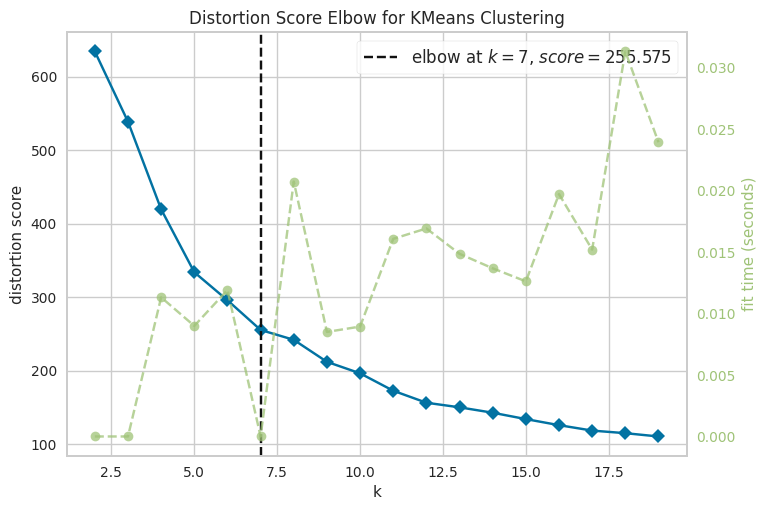

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [34]:
elbow_vis = KElbowVisualizer(KMeans(random_state=18), k=(2, 20))
elbow_vis.fit(df_escalado)
elbow_vis.show()

In [35]:
# Aplicamos modelo KMeans
kmeans = KMeans(n_clusters=6, random_state=18)
cluster = kmeans.fit_predict(df_escalado)
cluster

array([4, 4, 4, ..., 1, 1, 1], shape=(20635,), dtype=int32)

In [36]:
df_escalado['cluster'] = cluster
df_escalado

,MedInc,Latitude,Longitude,cluster
0,0.539668,0.567481,0.211155,4
1,0.538027,0.565356,0.212151,4
2,0.466028,0.564293,0.210159,4
3,0.354699,0.564293,0.209163,4
4,0.230776,0.564293,0.209163,1
...,...,...,...,...
20630,0.073130,0.737513,0.324701,1
20631,0.141853,0.738576,0.312749,1
20632,0.082764,0.732200,0.311753,1
20633,0.094295,0.732200,0.301793,1


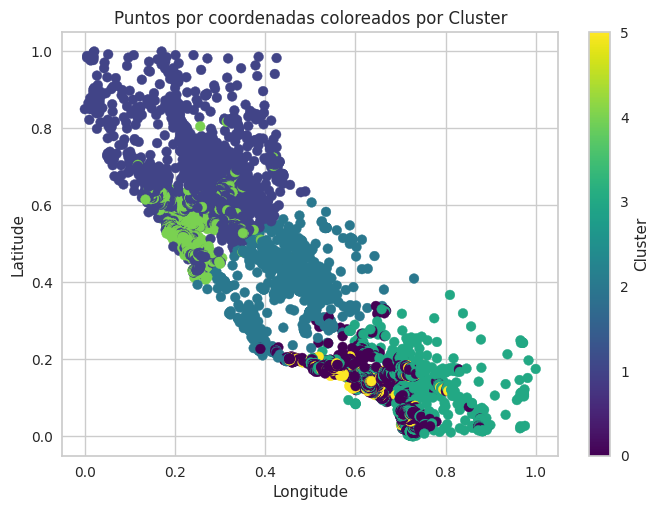

In [37]:
# Gráfico geográfico (Latitud vs Longitud)
scatter = plt.scatter(df_escalado["Longitude"], df_escalado["Latitude"], c=df_escalado["cluster"],cmap='viridis')

plt.title("Puntos por coordenadas coloreados por Cluster")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

cbar = plt.colorbar(scatter)
cbar.set_label('Cluster') 

plt.show()

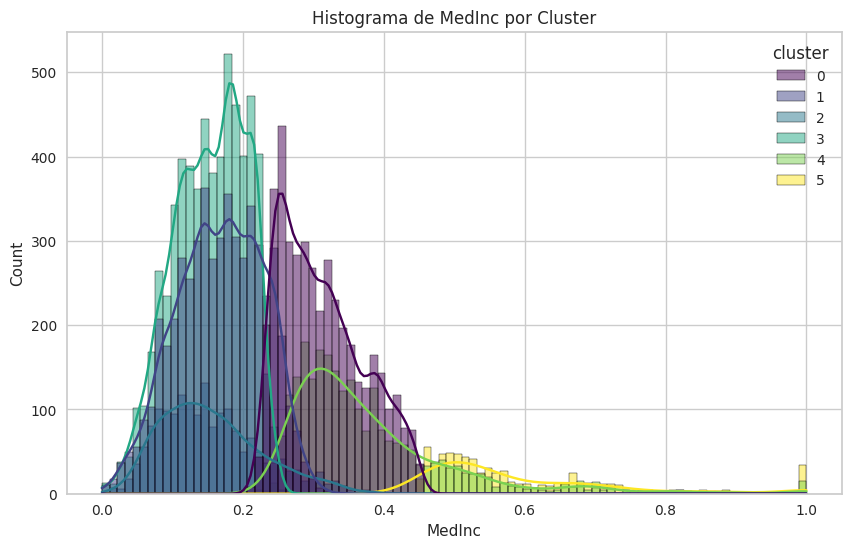

In [38]:
plt.figure(figsize=(10, 6))

# kde=True añade la línea de densidad suave sobre las barras
sns.histplot(data=df_escalado, x="MedInc", hue="cluster", kde=True, palette="viridis")

plt.title("Histograma de MedInc por Cluster")
plt.show()

> ### Observaciones:
> El modelo clasificó basandose en una cantidad de ingresos medio que tiene cada casa. En los casos donde la cantidad de ingresos son parecidos se enfoco en usar latitud y longitud para asignarle un grupo. Dejandonos grupos segun zonas e ingresos medios.

> Como ejemplo para que se entienda, diremos que hay personas con unos ingresos medios-bajos viviendo en zonas con personas que tienen altos ingresos.

##  Entrenamos un modelo de clasificación supervisada.
Usaré el modelo de KNN ya que este es útil cuando se tiene un conjunto de datos con relaciones no lineales. Como uno de sus usos es por ejemplo predecir el precio de una
casa basado en precios similares de propiedades cercanas.

Podríamos decir que esta base de datos el cluster sería el precio el medinc el precio medio de la casa y la longitud latitud las propiedades cercanas.


*Ahora que el K-Means nos ha devuelto una categorización (agrupación) de los puntos para los conjuntos de entrenamiento y prueba, estudia qué modelo podría ser más útil y entrénalo. Obtén las estadísticas y describe lo que ves.



### Split

In [39]:
X = df_escalado.drop('cluster', axis=1)
y = df_escalado['cluster']

# Instancia de: from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=18)

In [40]:
# Modelo
model = KNeighborsClassifier(n_neighbors=5)

# Entrenamiento
model.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [41]:
# Predicción
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [42]:
#accuracy_score
accuracy = {'Accuracy Test': accuracy_score(y_test, y_pred_test),
            'Accuracy Train': accuracy_score(y_train, y_pred_train)}
accuracy

{'Accuracy Test': 0.9915192633874486, 'Accuracy Train': 0.9950932881027381}

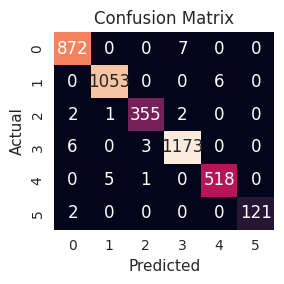

In [43]:
#confusion_matrix
confusionm = confusion_matrix(y_test, y_pred_test)

# Dibujaremos esta matriz para hacerla más visual
df_confusionm = pd.DataFrame(confusionm)

plt.figure(figsize=(3, 3))
sns.heatmap(df_confusionm, annot=True, fmt="d", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

In [44]:
#classification_report
clas_repor = classification_report(y_test, y_pred_test, output_dict=True)
df_clas_repor =pd.DataFrame(clas_repor).T
df_clas_repor

,precision,recall,f1-score,support
0,0.988662,0.992036,0.990346,879.000000
1,0.994334,0.994334,0.994334,1059.000000
2,0.988858,0.986111,0.987483,360.000000
3,0.992386,0.992386,0.992386,1182.000000
4,0.988550,0.988550,0.988550,524.000000
5,1.000000,0.983740,0.991803,123.000000
accuracy,0.991519,0.991519,0.991519,0.991519
macro avg,0.992132,0.989526,0.990817,4127.000000
weighted avg,0.991525,0.991519,0.991519,4127.000000


>### Observaciones:
>
> Todos los cluster con tanta precisión me da la sensación de sobreajuste, voy a hiperparametrizar a ver si bajo ambos un poco.

In [45]:
#hiperparámetrizacion

# Creo una lista de valores de k, del 1 al 40.
k_values = list(range(1, 41))

# Almacenaremos en estas listas la precisión de prueba y de entrenamiento para cada k.
test_accuracies = []
train_accuracies = []

# Con el bucle probaré los diferentes valores de k
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)

    y_pred_test_k = knn_model.predict(X_test)
    y_pred_train_k = knn_model.predict(X_train)

    test_acc = accuracy_score(y_test, y_pred_test_k)
    train_acc = accuracy_score(y_train, y_pred_train_k)

    test_accuracies.append(test_acc)
    train_accuracies.append(train_acc)

test_accuracies


[0.9920038769081657,
 0.990550036346014,
 0.9922461836685244,
 0.9907923431063727,
 0.9915192633874486,
 0.9912769566270899,
 0.9912769566270899,
 0.9922461836685244,
 0.9929731039496001,
 0.9915192633874486,
 0.9915192633874486,
 0.9907923431063727,
 0.9915192633874486,
 0.9898231160649382,
 0.9915192633874486,
 0.9912769566270899,
 0.9912769566270899,
 0.9900654228252969,
 0.9907923431063727,
 0.9912769566270899,
 0.9915192633874486,
 0.9907923431063727,
 0.9907923431063727,
 0.9903077295856555,
 0.9903077295856555,
 0.9890961957838623,
 0.9895808093045796,
 0.9895808093045796,
 0.990550036346014,
 0.9900654228252969,
 0.990550036346014,
 0.9903077295856555,
 0.990550036346014,
 0.990550036346014,
 0.9907923431063727,
 0.9900654228252969,
 0.990550036346014,
 0.9900654228252969,
 0.990550036346014,
 0.990550036346014]

> Todos los test están sobre el 99%

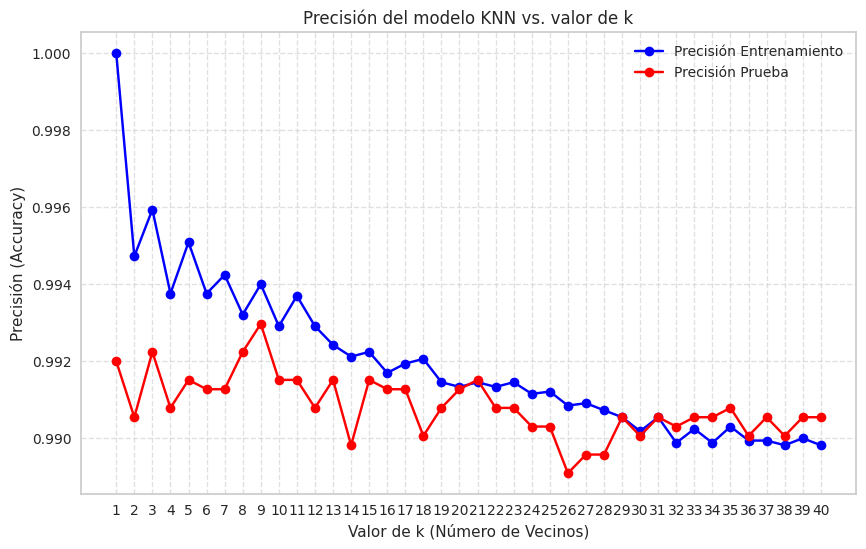

In [46]:
# Genero la Gráfica Accuracy vs k
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label='Precisión Entrenamiento', marker='o', color='blue')
plt.plot(k_values, test_accuracies, label='Precisión Prueba', marker='o', color='red')


plt.title('Precisión del modelo KNN vs. valor de k')
plt.xlabel('Valor de k (Número de Vecinos)')
plt.ylabel('Precisión (Accuracy)')
plt.xticks(k_values) 
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

## Observaciones:
> A simple vista podríamos decir que el K=39 es el que mejor valor nos podrá dar ya que es de los más bajos en precisión y que menos diferencia tiene entre test y train.
>
>Vamos a buscar a continuación el mejor K a ver si sale el mismo que se observa en la gráfica.

In [47]:
# Encontrar el mejor k
best_k_index = np.argmax(test_accuracies)
best_k = k_values[best_k_index]
best_accuracy = test_accuracies[best_k_index]

f"El mejor valor de k basado en la precisión de prueba es: {best_k} (Precisión: {best_accuracy:.4f})"

'El mejor valor de k basado en la precisión de prueba es: 9 (Precisión: 0.9930)'

> Aunque aquí nos dice que es el 9.

In [48]:
# Hiperparámetrizacion con RandomizedSearchCV con KNeighborsClassifier y n_neighbors 39.
hiper_params = {'n_neighbors': [39], 
                'algorithm':['auto','ball_tree', 'kd_tree', 'brute'],
                'weights': ['uniform', 'distance'],
                'p': [1, 1.15, 1.25, 1.5, 2], 
                'n_jobs':[1,2,3,4,5]}

random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=hiper_params,
                                   n_iter=50,
                                   cv=5,
                                   scoring='accuracy',
                                   random_state=42,
                                   n_jobs=-1)

random_search.fit(X_train, y_train)
random_search.best_params_

{'weights': 'distance',
 'p': 1.25,
 'n_neighbors': 39,
 'n_jobs': 5,
 'algorithm': 'ball_tree'}

In [49]:
random_search.best_score_

np.float64(0.9923068115658287)

In [50]:
# Aplico Modelo, con los resultados del best params.
model2 = KNeighborsClassifier(weights='distance', 
                              p=1.25,
                              n_neighbors=39, 
                              n_jobs=2, 
                              algorithm='ball_tree')

# Entrenamiento
model2.fit(X_train, y_train)

,n_neighbors,39
,weights,'distance'
,algorithm,'ball_tree'
,leaf_size,30
,p,1.25
,metric,'minkowski'
,metric_params,None
,n_jobs,2


In [51]:
# Predicción
y_pred_test2 = model2.predict(X_test)
y_pred_train2 = model2.predict(X_train)

In [52]:
#accuracy_score
accuracy = {'Accuracy Test': accuracy_score(y_test, y_pred_test2),
            'Accuracy Train': accuracy_score(y_train, y_pred_train2)}
accuracy

{'Accuracy Test': 0.9929731039496001, 'Accuracy Train': 1.0}

In [53]:
#classification_report
clas_repor = classification_report(y_test, y_pred_test2, output_dict=True)
df_clas_repor =pd.DataFrame(clas_repor).T
df_clas_repor

,precision,recall,f1-score,support
0,0.993174,0.993174,0.993174,879.000000
1,0.991557,0.998111,0.994824,1059.000000
2,0.983333,0.983333,0.983333,360.000000
3,0.994920,0.994078,0.994499,1182.000000
4,0.996154,0.988550,0.992337,524.000000
5,1.000000,0.983740,0.991803,123.000000
accuracy,0.992973,0.992973,0.992973,0.992973
macro avg,0.993190,0.990164,0.991662,4127.000000
weighted avg,0.992982,0.992973,0.992971,4127.000000


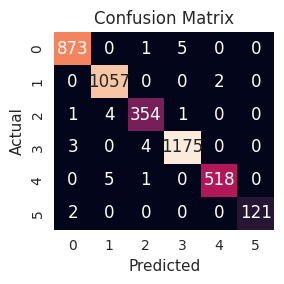

In [54]:
#confusion_matrix
confusionm = confusion_matrix(y_test, y_pred_test2)

# Dibujaremos esta matriz para hacerla más visual
df_confusionm = pd.DataFrame(confusionm)

plt.figure(figsize=(3, 3))
sns.heatmap(df_confusionm, annot=True, fmt="d", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

### Observaciones
> Aunque hemos hiperparametrizado al final no he conseguido bajar el train, al reves. se ha ajustado al 1, creando Overfitting.
> El resultado no mejora si pongo n_neighbors=9, también se ajusta al 1.

In [55]:
# Guardo el modelo de Kmeans y el primer modelo de clasificacion ya que me dió mejor resultado que hiperparámetrizado.

with open('../models/09-housing-modelknn.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('../models/09-housing-modelkmeans.pkl', 'wb') as f:
    pickle.dump(kmeans, f)
    

## Conclusión:
>K-Means:
>
>-Los clústeres se definieron principalmente por la cantidad de ingresos medios de cada casa.
>
>-En los casos donde los ingresos medios eran similares, el algoritmo se apoyó en la latitud y longitud para asignar el grupo, resultando en clústeres que reflejan una combinación de zona geográfica e ingresos medios.
>
>-Esta segmentación sugiere una fuerte correlación entre la ubicación y el poder adquisitivo, lo que es un hallazgo valioso para caracterizar los tipos de viviendas en el dataset.

>KNN:
>
>-Accuracy: El modelo base tiene un rendimiento excepcional, clasificando correctamente casi el 99.2% de las instancias.
>
>-Precision & Recall: Alto por encima del 98.8 en todas las clases, muestra que el modelo es muy bueno tanto evitando falsos positivos (Precision) como encontrando todos los positivos reales (Recall) en cada uno de los clústeres.

>Hiperparametrización:
>
>-El intento de optimizar el modelo mediante la hiperparametrización me llevó a un rendimiento en entrenamiento de 1.00. Esto significa que el modelo memorizó los datos de entrenamiento y perdió su capacidad de generalización.
>
>-Motivo por el que lo descarto y guardo el primer modelo.
